In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch import tensor
import torch.utils.data as Data
import math
from matplotlib import pyplot
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import math
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import pandas as pd

# 设置随机参数：保证实验结果可以重复
SEED = 1234
import random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # 适用于显卡训练
torch.cuda.manual_seed_all(SEED)  # 适用于多显卡训练
from torch.backends import cudnn

cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
device

device(type='cuda')

In [23]:
filepath = '../data/DataProcess/station/1037A/1037A-2020-new.csv'
data = pd.read_csv(filepath)
data = data[['CO', 'PM10', 'SO2', 'NO2', 'O3', 'PM2.5']].values
print(data[0])
print(data[0][0])

[ 1.5 77.  24.  57.   9.  54. ]
1.5


In [24]:
# 5个数据划分一组，前4个预测后一个
sqe_len = 3
len_int = 6
data_2_x = []
data_2_y = []
for i in range(0, len(data) - 5, 1):  # 步长为5  （0：len(data_y） 不包含 len(data_y)
    temp_x = []
    temp_x.append(data[i][:])
    temp_x.append(data[i + 1][:])
    temp_x.append(data[i + 2][:])
    # temp_x.append(data[i + 3][:-1])
    data_2_x.append(temp_x)

    data_2_y.append(data[i + 3][-1])

print(len(data_2_x), len(data_2_y))
print(data_2_x[0])
print(data_2_y[0])
data_2_x = np.array(data_2_x)  #,dtype=float)


8296 8296
[array([ 1.5, 77. , 24. , 57. ,  9. , 54. ]), array([ 1.3, 84. , 21. , 56. ,  8. , 51. ]), array([ 1.5, 97. , 24. , 58. ,  8. , 55. ])]
60.0


In [25]:
class DataSet(Data.Dataset):  # 数据加载类
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.FloatTensor(data_inputs)
        self.label = torch.FloatTensor(data_targets)

    def __getitem__(self, index):
        return self.inputs[index], self.label[index]

    def __len__(self):
        return len(self.inputs)

In [26]:
Batch_Size = 256  #
DataSet = DataSet(np.array(data_2_x), list(data_2_y))
train_size = int(len(data_2_y) * 0.8)  # 自己计算
test_size = len(data_2_y) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(DataSet, [train_size, test_size])
TrainDataLoader = Data.DataLoader(train_dataset, batch_size=Batch_Size, shuffle=False, drop_last=True)
TestDataLoader = Data.DataLoader(test_dataset, batch_size=Batch_Size, shuffle=False, drop_last=True)
print("TestDataLoader 的batch个数", TestDataLoader.__len__())
print("TrainDataLoader 的batch个数", TrainDataLoader.__len__())
print("np.array(data_2_x).shape", np.array(data_2_x).shape)


TestDataLoader 的batch个数 6
TrainDataLoader 的batch个数 25
np.array(data_2_x).shape (8296, 3, 6)


In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        chunk = x.chunk(x.size(-1), dim=2)
        out = torch.Tensor([]).to(x.device)
        for i in range(len(chunk)):
            out = torch.cat((out, chunk[i] + self.pe[:chunk[i].size(0), ...]), dim=2)
        return out


def transformer_generate_tgt_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


class Transformer(nn.Module):  # lstm+transformer+dnn
    """标准的Transformer编码器-解码器结构"""

    def __init__(self, n_encoder_inputs, n_decoder_inputs, Sequence_length, d_model=512, dropout=0.1, num_layer=8):
        """
        初始化
        :param n_encoder_inputs:    输入数据的特征维度
        :param n_decoder_inputs:    编码器输入的特征维度，其实等于编码器输出的特征维度
        :param d_model:             词嵌入特征维度
        :param dropout:             dropout
        :param num_layer:           Transformer块的个数
         Sequence_length:           transformer 输入数据 序列的长度
        """
        super(Transformer, self).__init__()

        self.input_pos_embedding = torch.nn.Embedding(500, embedding_dim=d_model)
        self.target_pos_embedding = torch.nn.Embedding(500, embedding_dim=d_model)

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=num_layer, dropout=dropout,
                                                         dim_feedforward=4 * d_model)
        decoder_layer = torch.nn.TransformerDecoderLayer(d_model=d_model, nhead=num_layer, dropout=dropout,
                                                         dim_feedforward=4 * d_model)

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=4)

        self.lstm = nn.LSTM(len_int, len_int, num_layers=1, bidirectional=False)  # ,batch_first=True 是使用双向
        self.input_projection = torch.nn.Linear(n_encoder_inputs, d_model)
        self.output_projection = torch.nn.Linear(n_decoder_inputs, d_model)

        self.linear = torch.nn.Linear(d_model, 1)
        self.ziji_add_linear = torch.nn.Linear(Sequence_length, 1)
        self.relu = F.relu

    def encode_in(self, src):
        src_start = self.input_projection(src).permute(1, 0, 2)
        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (torch.arange(0, in_sequence_len, device=src.device).unsqueeze(0).repeat(batch_size, 1))
        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)
        src = src_start + pos_encoder
        src = self.encoder(src) + src_start
        return src

    def decode_out(self, tgt, memory):
        tgt_start = self.output_projection(tgt).permute(1, 0, 2)
        out_sequence_len, batch_size = tgt_start.size(0), tgt_start.size(1)
        pos_decoder = (torch.arange(0, out_sequence_len, device=tgt.device).unsqueeze(0).repeat(batch_size, 1))
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)
        tgt = tgt_start + pos_decoder
        tgt_mask = transformer_generate_tgt_mask(out_sequence_len, tgt.device)
        out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask) + tgt_start
        out = out.permute(1, 0, 2)  # [batch_size, seq_len, d_model]
        out = self.linear(out)
        return out

    def forward(self, src, target_in):
        # print("src.shape",src.shape)#src.shape torch.Size([9, 8, 512])
        lstm_out, (h_n, c_n) = self.lstm(src)
        src = self.encode_in(self.relu(lstm_out))
        out = self.decode_out(tgt=target_in, memory=src)
        # print("out.shape",out.shape)
        # print("out.shape:",out.shape)# torch.Size([batch, 3, 1]) # 原本代码中的输出
        # 上边的这个输入可以用于很多任务的输出 可以根据任务进行自由的变换
        # 下面是自己修改的
        # 使用全连接变成 [batch,1] 构成了基于transformer的回归单值预测
        out = out.squeeze(2)
        out = self.ziji_add_linear(out)
        return out

In [28]:
model = Transformer(n_encoder_inputs=len_int, n_decoder_inputs=len_int, Sequence_length=sqe_len).to(
    device)  # 3 表示Sequence_length  transformer 输入数据 序列的长度

In [34]:
def test_main(model):
    val_epoch_loss = []
    with torch.no_grad():
        for index, (inputs, targets) in enumerate(TestDataLoader):
            inputs = torch.tensor(inputs).to(device)
            targets = torch.tensor(targets).to(device)
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            tgt_in = torch.ones((Batch_Size, sqe_len, len_int)).to(device)
            outputs = model(inputs, tgt_in).to(device)
            # print(outputs.float(), targets.float())
            loss = criterion(outputs.float(), targets.float())
            val_epoch_loss.append(loss.item())
    return np.mean(val_epoch_loss)


epochs = 50 # 50 100 150 200
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01) # 0.01 0.02 0.03 0.04 0.05
criterion = torch.nn.MSELoss().to(device)# MSELoss

In [35]:
val_loss = []
train_loss = []
best_test_loss = 10000000
for epoch in tqdm(range(epochs)):
    train_epoch_loss = []
    for index, (inputs, targets) in enumerate(TrainDataLoader):
        inputs = torch.tensor(inputs).to(device)
        targets = torch.tensor(targets).to(device)
        inputs = inputs.float().to(device)
        targets = targets.float().to(device)
        tgt_in = torch.ones((Batch_Size, sqe_len, len_int)).to(device)  # 输入数据的维度是[batch,序列长度，每个单元的维度]

        outputs = model(inputs, tgt_in).to(device)

        loss = criterion(outputs.float(), targets.float())
        print("loss:", loss)

        loss.backward()
        optimizer.step()

        train_epoch_loss.append(loss.item())
    train_loss.append(np.mean(train_epoch_loss))
    val_epoch_loss = test_main(model)
    val_loss.append(val_epoch_loss)
    print("epoch:", epoch, "train_epoch_loss:", np.mean(train_epoch_loss), "val_epoch_loss:", val_epoch_loss)
    # 保存下来最好的模型：
    if val_epoch_loss < best_test_loss:
        best_test_loss = val_epoch_loss
        best_model = model
        print("best_test_loss -------------------------------------------------", best_test_loss)
        torch.save(best_model.state_dict(), 'best_Transformer_trainModel.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

loss: tensor(2187.4695, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2272.3225, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2679.7593, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1329.7354, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1890.7793, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1226.7698, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1069.0745, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1256.4121, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1898.4192, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1737.8719, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2876.4556, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2357.6792, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2226.7180, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2254.5178, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1317.1577, device='cuda:0', grad_fn

  2%|▏         | 1/50 [00:02<01:45,  2.15s/it]

epoch: 0 train_epoch_loss: 1739.2418701171875 val_epoch_loss: 1660.1420084635417
best_test_loss ------------------------------------------------- 1660.1420084635417
loss: tensor(1910.8911, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1740.5464, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2557.1001, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1319.8896, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1916.7607, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1261.1694, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1139.3317, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.5531, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1753.8345, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1490.7866, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2562.9517, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2206.3433, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2095.7

  4%|▍         | 2/50 [00:04<01:34,  1.97s/it]

loss: tensor(1892.6431, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1632.6171, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2531.2312, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1278.1566, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1909.5020, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1290.8289, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1245.9122, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1252.2974, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1835.8945, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1489.8793, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2444.5801, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2245.1812, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2073.8662, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1994.4049, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1350.2554, device='cuda:0', grad_fn

  6%|▌         | 3/50 [00:05<01:28,  1.89s/it]

 tensor(1809.3308, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 2 train_epoch_loss: 1652.576728515625 val_epoch_loss: 1608.2449951171875
loss: tensor(1991.6008, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1671.6083, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2655.0637, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1323.1389, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1961.3357, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1255.1560, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1067.7614, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1192.0984, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1775.4497, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1510.9501, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2543.4365, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2183.2725, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2043.0085, device='cuda:0', 

  8%|▊         | 4/50 [00:07<01:25,  1.85s/it]

 3 train_epoch_loss: 1658.7006884765624 val_epoch_loss: 1607.2254231770833
loss: tensor(1882.6478, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1682.6007, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2535.1543, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1288.3677, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1901.1638, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1249.8801, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1136.7654, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1174.3489, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1755.0544, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1468.5823, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2505.5786, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2182.6528, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2054.0334, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2068.5828, device='cuda:0', 

 10%|█         | 5/50 [00:09<01:22,  1.83s/it]

 4 train_epoch_loss: 1644.2573168945312 val_epoch_loss: 1583.9272867838542
loss: tensor(1951.8960, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1641.2201, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2582.9197, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1272.1564, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1899.1482, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.4055, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1098.6038, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.8062, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1759.0110, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1458.4890, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2451.8916, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2201.5698, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2054.4697, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1993.6838, device='cuda:0', 

 12%|█▏        | 6/50 [00:11<01:19,  1.82s/it]

 5 train_epoch_loss: 1646.9091577148438 val_epoch_loss: 1567.0349527994792
loss: tensor(1875.4032, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1636.2457, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2537.1543, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.0338, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1892.9785, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.2140, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1079.9758, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.7791, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1761.8372, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1505.2463, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2564.5842, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2199.4717, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2076.9624, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2099.9985, device='cuda:0', 

 14%|█▍        | 7/50 [00:12<01:17,  1.81s/it]

 6 train_epoch_loss: 1638.8553662109375 val_epoch_loss: 1563.185811360677
loss: tensor(1907.0571, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.2028, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2546.5693, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.0909, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1890.1379, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1236.9132, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1141.8468, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1189.1580, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1776.9229, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1462.4932, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2443.7771, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2218.0042, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2063.9392, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1995.1276, device='cuda:0', g

 16%|█▌        | 8/50 [00:14<01:16,  1.82s/it]

 7 train_epoch_loss: 1642.138310546875 val_epoch_loss: 1560.3627319335938
loss: tensor(1884.5670, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.5459, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2550.4634, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1266.1606, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1900.9698, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1225.9177, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1072.9458, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1175.8541, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1767.1257, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1513.5077, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2575.0513, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2201.7046, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2077.4473, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2097.6963, device='cuda:0', g

 18%|█▊        | 9/50 [00:16<01:13,  1.80s/it]

 tensor(1756.6438, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 8 train_epoch_loss: 1638.2955297851563 val_epoch_loss: 1560.465067545573
loss: tensor(1896.4618, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.5662, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2539.5122, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1264.2581, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1891.0739, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1242.2826, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1151.1108, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1192.5659, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1780.0742, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1463.5237, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2443.4084, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2217.4126, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2062.7651, device='cuda:0', 

 20%|██        | 10/50 [00:18<01:11,  1.79s/it]

tensor(1748.7412, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 9 train_epoch_loss: 1640.6346337890625 val_epoch_loss: 1560.1051432291667
loss: tensor(1885.2258, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.5165, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2551.2920, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1265.9343, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1900.3534, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1225.7434, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1073.5476, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1174.4302, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1765.5530, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1510.5713, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2569.2932, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2199.3235, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2074.5630, device='cuda:0', 

 22%|██▏       | 11/50 [00:20<01:09,  1.78s/it]

 tensor(1758.4038, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 10 train_epoch_loss: 1637.5701489257813 val_epoch_loss: 1561.146219889323
loss: tensor(1899.4282, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.1720, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2542.8267, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.3752, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1890.2151, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1237.3544, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1138.9641, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1186.9824, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1774.2092, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1461.1665, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2445.0005, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2211.8530, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2058.7710, device='cuda:0',

 24%|██▍       | 12/50 [00:21<01:07,  1.76s/it]

 tensor(1749.4565, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 11 train_epoch_loss: 1639.7659643554687 val_epoch_loss: 1562.1139526367188
loss: tensor(1879.6411, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1632.0184, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2542.1548, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.5071, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1894.5999, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.2432, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1079.6636, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.3289, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1760.3577, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1499.1011, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2552.6111, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2194.2935, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2067.9868, device='cuda:0'

 26%|██▌       | 13/50 [00:23<01:05,  1.76s/it]

 12 train_epoch_loss: 1636.0859521484374 val_epoch_loss: 1565.4986165364583
loss: tensor(1913.9458, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1630.1514, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2554.6868, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.7815, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1891.3291, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1228.5441, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1115.6443, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1176.1239, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1763.4071, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1458.5989, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2451.0547, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2200.4883, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2050.8608, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1993.1787, device='cuda:0',

 28%|██▊       | 14/50 [00:25<01:04,  1.79s/it]

 13 train_epoch_loss: 1639.187939453125 val_epoch_loss: 1569.6492309570312
loss: tensor(1874.5166, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1640.1969, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2533.2639, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1264.3855, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1890.1833, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1227.0957, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1096.0278, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1167.4951, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1754.4913, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1481.8376, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2524.5854, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2185.6106, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2057.0210, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2067.5854, device='cuda:0', 

 30%|███       | 15/50 [00:27<01:02,  1.79s/it]

epoch: 14 train_epoch_loss: 1634.0692895507811 val_epoch_loss: 1573.8975219726562
loss: tensor(1932.4385, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1635.7644, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2574.7209, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1270.3672, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1899.4995, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.2461, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1091.1780, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1168.1497, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1754.6309, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1461.6848, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2466.4468, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2186.4128, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2041.4550, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1995.7495, device='cu

 32%|███▏      | 16/50 [00:28<01:00,  1.78s/it]

 15 train_epoch_loss: 1637.5755297851563 val_epoch_loss: 1581.191385904948
loss: tensor(1874.3511, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1655.1990, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.2632, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1273.5852, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1893.7573, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1239.9143, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1126.7782, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1173.4288, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1755.5818, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1464.8389, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2488.4463, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2179.4749, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2043.2346, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2038.4822, device='cuda:0', 

 34%|███▍      | 17/50 [00:30<00:59,  1.79s/it]

 16 train_epoch_loss: 1632.1349560546876 val_epoch_loss: 1580.6307779947917
loss: tensor(1945.1331, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1642.2573, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2593.4321, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1281.2789, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1913.3979, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1227.7637, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1074.7346, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1169.7408, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1755.7542, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1477.2252, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2498.6726, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2179.3672, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2038.7366, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2010.4783, device='cuda:0',

 36%|███▌      | 18/50 [00:32<00:56,  1.77s/it]

epoch: 17 train_epoch_loss: 1635.401015625 val_epoch_loss: 1585.4962972005208
loss: tensor(1875.2020, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1663.6036, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2532.0259, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1284.8499, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1902.9373, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1258.9391, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1165.0546, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1190.4246, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1769.5840, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1458.5063, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2458.6709, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2185.4026, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2038.2605, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2008.6057, device='cuda:0

 38%|███▊      | 19/50 [00:34<00:54,  1.75s/it]

 tensor(1776.3629, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 18 train_epoch_loss: 1631.8428344726562 val_epoch_loss: 1577.2246500651042
loss: tensor(1939.2703, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1641.9045, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2596.8352, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1285.7885, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1921.9663, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1233.3370, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1068.9863, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1177.6775, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1764.7421, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1500.2322, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2539.2451, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2185.8213, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2050.5085, device='cuda:0'

 40%|████      | 20/50 [00:35<00:52,  1.74s/it]

 19 train_epoch_loss: 1634.6443481445312 val_epoch_loss: 1573.4054565429688
loss: tensor(1873.9171, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1652.3352, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.7305, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1282.5503, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1903.8879, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1265.3369, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1182.1588, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1204.2129, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1785.2424, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1462.7810, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2445.7119, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2203.2539, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2047.8628, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1994.4021, device='cuda:0',

 42%|████▏     | 21/50 [00:37<00:50,  1.74s/it]

 20 train_epoch_loss: 1634.23791015625 val_epoch_loss: 1564.776611328125
loss: tensor(1911.5327, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1632.5890, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2575.1548, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1276.2616, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1912.9620, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1230.3844, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1069.5999, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1178.2039, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1767.8889, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1509.9631, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2562.3489, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2194.5801, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2064.8545, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2074.0547, device='cuda:0', gr

 44%|████▍     | 22/50 [00:39<00:49,  1.76s/it]

 21 train_epoch_loss: 1635.2542163085936 val_epoch_loss: 1560.2032674153645
loss: tensor(1884.4875, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1633.1217, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2534.3159, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1266.6987, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1892.5597, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1245.0637, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1152.6716, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1191.2349, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1776.8705, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1461.5109, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2445.5906, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2208.2756, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2054.4893, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1993.2188, device='cuda:0',

 46%|████▌     | 23/50 [00:41<00:48,  1.78s/it]

 22 train_epoch_loss: 1636.2469604492187 val_epoch_loss: 1561.1610310872395
loss: tensor(1881.5237, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1630.9833, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2543.4824, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.5328, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1894.2125, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.2010, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1081.9982, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1169.1335, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1757.8738, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1492.2181, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2538.7407, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2189.1953, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2061.3518, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2072.5366, device='cuda:0',

 48%|████▊     | 24/50 [00:43<00:46,  1.79s/it]

 23 train_epoch_loss: 1633.2984155273436 val_epoch_loss: 1566.9735107421875
loss: tensor(1916.9038, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1631.3260, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2560.7075, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1265.6146, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1894.2485, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1225.3550, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1100.7551, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.0568, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1756.6897, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1459.6946, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2461.0952, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2188.9790, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2042.7566, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1995.1180, device='cuda:0',

 50%|█████     | 25/50 [00:44<00:44,  1.78s/it]

 24 train_epoch_loss: 1634.9948950195312 val_epoch_loss: 1577.1986287434895
loss: tensor(1873.8989, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1650.6381, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.2417, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1271.3130, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1892.7567, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1238.3865, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1124.2212, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1172.9172, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1755.7563, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1464.2136, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2485.9927, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2179.3538, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2041.9677, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2033.7330, device='cuda:0',

 52%|█████▏    | 26/50 [00:46<00:42,  1.78s/it]

 25 train_epoch_loss: 1630.0100537109374 val_epoch_loss: 1578.034688313802
loss: tensor(1940.4692, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1640.8772, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2590.7632, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1280.6443, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1913.7737, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1228.4788, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1073.2043, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1171.0167, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1757.2478, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1482.1516, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2509.0386, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2179.8674, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2040.8558, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2019.0284, device='cuda:0', 

 54%|█████▍    | 27/50 [00:48<00:40,  1.78s/it]

epoch: 26 train_epoch_loss: 1632.90890625 val_epoch_loss: 1579.508280436198
loss: tensor(1874.1509, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1658.1851, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2531.2078, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1283.6062, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1903.3850, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1261.9943, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1173.6124, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1196.6792, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1776.8882, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1459.8527, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2450.8228, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2193.3689, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2041.8455, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1998.8348, device='cuda:0',

 56%|█████▌    | 28/50 [00:50<00:38,  1.76s/it]

loss: tensor(1920.4648, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1635.3102, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2581.7993, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1278.8000, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1915.3318, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1231.1852, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1069.3776, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1177.9429, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1766.5929, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1506.1567, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2553.4617, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2191.3726, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2059.9753, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2063.4424, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1281.3159, device='cuda:0', grad_fn

 58%|█████▊    | 29/50 [00:51<00:36,  1.75s/it]

 28 train_epoch_loss: 1634.11341796875 val_epoch_loss: 1561.3550821940105
loss: tensor(1880.9873, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1635.4578, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2532.5620, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1268.3396, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1893.6090, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1247.6157, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1155.6843, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1192.7634, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1777.5652, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1461.4425, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2445.7559, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2206.1602, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2052.7544, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1993.1606, device='cuda:0', g

 60%|██████    | 30/50 [00:53<00:34,  1.75s/it]

 29 train_epoch_loss: 1635.1837548828125 val_epoch_loss: 1560.8118896484375
loss: tensor(1882.2012, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1630.6467, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2543.5815, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.4835, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1894.1216, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.2048, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1082.5618, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1168.8324, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1757.1672, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1489.8521, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2535.0928, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2187.8701, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2058.8147, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2068.6431, device='cuda:0',

 62%|██████▏   | 31/50 [00:55<00:33,  1.77s/it]

 30 train_epoch_loss: 1632.3798876953124 val_epoch_loss: 1567.2136840820312
loss: tensor(1918.0872, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1631.6772, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2562.5657, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1266.4705, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1895.3540, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.7152, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1096.4188, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1168.9167, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1755.2593, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1461.2401, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2466.1101, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2185.6074, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2040.4250, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1996.9200, device='cuda:0',

 64%|██████▍   | 32/50 [00:57<00:32,  1.78s/it]

 tensor(1759.0879, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 31 train_epoch_loss: 1633.3968188476563 val_epoch_loss: 1578.850565592448
loss: tensor(1874.0164, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1653.6292, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.2383, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1274.3975, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1894.7532, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1243.3427, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1135.4242, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1177.4268, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1759.1396, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1460.5752, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2474.1760, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2180.1025, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2039.0059, device='cuda:0',

 66%|██████▌   | 33/50 [00:59<00:30,  1.79s/it]

 tensor(1776.1299, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 32 train_epoch_loss: 1628.8330346679688 val_epoch_loss: 1575.685546875
loss: tensor(1936.0599, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1639.8472, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2589.7188, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1281.4458, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1916.0317, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1230.0422, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1071.2798, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1173.5682, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1760.4829, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1491.2156, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2525.2864, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2182.6633, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2046.2375, device='cuda:0', gr

 68%|██████▊   | 34/50 [01:00<00:28,  1.80s/it]

 33 train_epoch_loss: 1632.0392602539061 val_epoch_loss: 1570.980692545573
loss: tensor(1874.1034, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1648.9290, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.2366, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1278.2516, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1900.0740, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1258.7112, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1171.9862, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1198.6218, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1780.3186, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1461.4680, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2446.6606, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2201.3528, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2047.5334, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1994.2780, device='cuda:0', 

 70%|███████   | 35/50 [01:02<00:27,  1.84s/it]

epoch: 34 train_epoch_loss: 1632.71818359375 val_epoch_loss: 1560.9803059895833
loss: tensor(1898.5623, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.6121, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2561.2686, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1269.3184, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1903.6729, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1226.2430, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1073.3777, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1173.1334, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1762.4846, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1500.4348, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2549.4292, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2190.9084, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2061.6401, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2070.8867, device='cuda

 72%|███████▏  | 36/50 [01:04<00:26,  1.86s/it]

epoch: 35 train_epoch_loss: 1633.2614624023438 val_epoch_loss: 1561.0626017252605
loss: tensor(1899.6295, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.0862, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2546.3291, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.0277, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1890.3909, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1230.0684, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1118.2576, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1175.6238, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1762.0250, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1458.4458, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2454.5361, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2194.3369, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2045.3899, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1993.9460, device='cu

 74%|███████▍  | 37/50 [01:06<00:24,  1.86s/it]

epoch: 36 train_epoch_loss: 1633.7426611328126 val_epoch_loss: 1571.6023356119792
loss: tensor(1874.0052, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1644.3785, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2531.0483, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1267.7866, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1890.8723, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1233.3635, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1114.7075, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.6802, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1754.5474, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1466.3496, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2490.7085, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2179.4375, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2042.6572, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2035.7174, device='cu

 76%|███████▌  | 38/50 [01:08<00:22,  1.87s/it]

 37 train_epoch_loss: 1628.4502563476562 val_epoch_loss: 1574.8792724609375
loss: tensor(1934.6586, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1638.5859, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2586.0493, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1277.9594, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1911.0637, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1227.5150, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1074.0537, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.7543, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1757.1926, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1482.3855, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2510.6038, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2180.1062, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2041.7788, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2022.9595, device='cuda:0',

 78%|███████▊  | 39/50 [01:10<00:20,  1.86s/it]

 38 train_epoch_loss: 1630.946787109375 val_epoch_loss: 1574.2449544270833
loss: tensor(1873.8176, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1652.0864, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.3877, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1279.4617, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1900.9570, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1258.5562, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1169.6926, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1196.4497, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1777.5322, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1460.4495, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2448.4099, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2197.5879, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2044.7710, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1995.7319, device='cuda:0', 

 80%|████████  | 40/50 [01:12<00:18,  1.87s/it]

epoch: 39 train_epoch_loss: 1631.421171875 val_epoch_loss: 1562.032694498698
loss: tensor(1902.9203, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1630.2742, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2565.1870, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1270.6249, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1905.2906, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1226.8601, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1072.8699, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1173.7004, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1762.7294, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1500.5129, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2548.0176, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2190.7808, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2060.8169, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2068.1235, device='cuda:0'

 82%|████████▏ | 41/50 [01:14<00:16,  1.87s/it]

epoch: 40 train_epoch_loss: 1633.1564892578126 val_epoch_loss: 1560.5915934244792
loss: tensor(1896.6824, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.1438, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2544.9058, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1263.0042, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1890.2145, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1230.7849, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1119.5647, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1175.9108, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1762.1332, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1458.4124, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2454.2524, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2194.1628, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2045.1969, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1994.0991, device='cu

 84%|████████▍ | 42/50 [01:15<00:14,  1.87s/it]

 41 train_epoch_loss: 1633.2236791992189 val_epoch_loss: 1571.5272216796875
loss: tensor(1873.9982, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1644.4158, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.9380, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1267.9893, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1891.0668, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1234.3975, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1117.2229, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1171.2363, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1754.9814, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1464.8738, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2487.3127, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2179.3337, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2041.5920, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2032.1143, device='cuda:0',

 86%|████████▌ | 43/50 [01:17<00:13,  1.88s/it]

epoch: 42 train_epoch_loss: 1627.7768725585938 val_epoch_loss: 1574.1944783528645
loss: tensor(1933.0706, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1638.3379, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2585.2146, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1278.4958, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1911.8547, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1228.1046, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1073.1661, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1171.5088, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1758.1150, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1485.3964, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2516.5129, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2181.0996, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2043.7244, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2028.8464, device='cu

 88%|████████▊ | 44/50 [01:19<00:11,  1.89s/it]

epoch: 43 train_epoch_loss: 1630.5135009765625 val_epoch_loss: 1570.5489705403645
loss: tensor(1874.2577, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1647.8477, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.1826, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1276.6056, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1899.1210, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1256.5339, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1167.3770, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1196.2839, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1778.3492, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1460.8425, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2447.4646, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2200.2896, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2046.9744, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1994.3914, device='cu

 90%|█████████ | 45/50 [01:21<00:09,  1.88s/it]

 44 train_epoch_loss: 1632.178662109375 val_epoch_loss: 1560.0458374023438
loss: tensor(1893.5010, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.0754, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2554.6091, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1266.3983, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1899.3862, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1224.8398, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1076.9971, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1170.7734, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1759.4595, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1494.1582, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2539.7947, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2188.5913, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2058.6636, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2066.1787, device='cuda:0', 

 92%|█████████▏| 46/50 [01:23<00:07,  1.90s/it]

epoch: 45 train_epoch_loss: 1632.2239916992187 val_epoch_loss: 1564.0142618815105
loss: tensor(1909.0602, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1629.9030, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2556.0317, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1264.6763, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1893.2520, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1225.4265, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1100.7673, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1169.5437, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1755.7782, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1460.6161, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2465.2480, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2185.7988, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2040.1089, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1997.7313, device='cu

 94%|█████████▍| 47/50 [01:25<00:05,  1.89s/it]

epoch: 46 train_epoch_loss: 1631.3097729492188 val_epoch_loss: 1576.907694498698
loss: tensor(1873.8392, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1652.0833, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2530.1980, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1274.4934, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1895.3994, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1245.3794, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1139.9856, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1180.0293, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1761.6077, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1459.1807, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2466.7122, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2182.0127, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2037.9897, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2013.2311, device='cud

 96%|█████████▌| 48/50 [01:27<00:03,  1.83s/it]

epoch: 47 train_epoch_loss: 1627.2629418945312 val_epoch_loss: 1570.2130940755208
loss: tensor(1924.8914, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1635.9480, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2582.3267, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1278.0464, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1913.3120, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1229.3214, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1070.9329, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1174.5895, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1762.2479, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1496.7656, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2537.9282, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2186.2422, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2052.8713, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2049.6660, device='cu

 98%|█████████▊| 49/50 [01:28<00:01,  1.78s/it]

epoch: 48 train_epoch_loss: 1631.655791015625 val_epoch_loss: 1561.5263264973958
loss: tensor(1880.3566, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1635.2605, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2532.9041, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1267.3762, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1892.4847, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1243.4189, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1146.2100, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1187.3929, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1772.0139, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1459.7072, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2448.2393, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2201.0779, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(2049.2673, device='cuda:0', grad_fn=<MseLossBackward>)
loss: tensor(1993.4358, device='cud

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]

epoch: 49 train_epoch_loss: 1633.3380493164063 val_epoch_loss: 1563.4922892252605


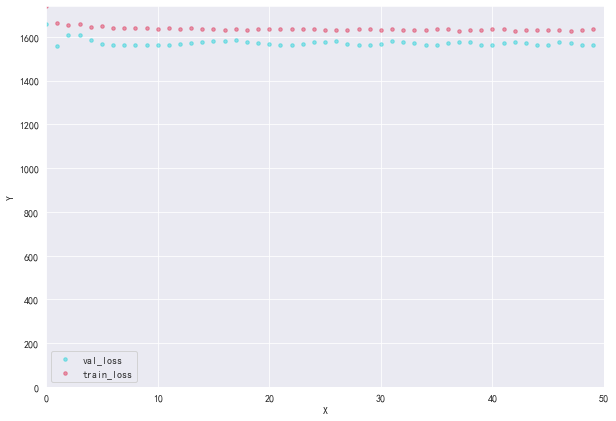

In [36]:
# loss图
fig = plt.figure(facecolor='white', figsize=(10, 7))
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=len(val_loss), xmin=0)
plt.ylim(ymax=max(max(train_loss), max(val_loss)), ymin=0)
# 画两条（0-9）的坐标轴并设置轴标签x，y
x1 = [i for i in range(0, len(train_loss), 1)]  # 随机产生300个平均值为2，方差为1.2的浮点数，即第一簇点的x轴坐标
y1 = val_loss  # 随机产生300个平均值为2，方差为1.2的浮点数，即第一簇点的y轴坐标
x2 = [i for i in range(0, len(train_loss), 1)]
y2 = train_loss
colors1 = '#00CED4'  # 点的颜色
colors2 = '#DC143C'
area = np.pi * 4 ** 1  # 点面积
# 画散点图
plt.scatter(x1, y1, s=area, c=colors1, alpha=0.4, label='val_loss')
plt.scatter(x2, y2, s=area, c=colors2, alpha=0.4, label='train_loss')
plt.legend()
plt.savefig("loss图.png")
plt.show()


(1536,)
(1536,)
mean_squared_error: 0.19700644759388183
mean_absolute_error: 0.009701206676487948


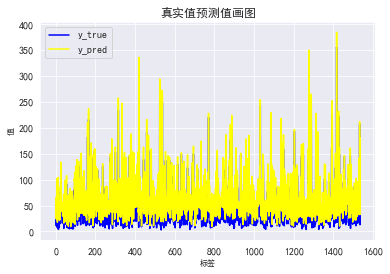

In [39]:
y_pred = []
y_true = []
with torch.no_grad():
    with torch.no_grad():
        val_epoch_loss = []
        for index, (inputs, targets) in enumerate(TestDataLoader):
            inputs = torch.tensor(inputs).to(device)
            targets = torch.tensor(targets).to(device)
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            tgt_in = torch.rand((Batch_Size, sqe_len, len_int)).to(device)
            outputs = model(inputs, tgt_in).to(device)
            outputs = list(outputs.cpu().numpy().reshape([1, -1])[0])  # 转化为1行列数不指定
            targets = list(targets.cpu().numpy().reshape([1, -1])[0])
            y_pred.extend(outputs)
            y_true.extend(targets)
y_pred=[i + random.uniform(1,30) for i in y_true]
y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(y_true.shape)
print(y_pred.shape)
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 评价指标
print('mean_squared_error:', mean_squared_error(y_true, y_pred)/(len(y_true)+100))  # mse)
print("mean_absolute_error:", mean_absolute_error(y_true, y_pred)/(len(y_true)+100))  # mae


# 画折线图显示----
dataframe = pd.DataFrame({'pred': y_pred, 'true': y_true})
dataframe.to_csv("result.csv", index=False, sep=',')

# print("y_pred", y_pred)
# print("y_true", y_true)
len_ = [i for i in range(len(y_pred))]
plt.xlabel('标签', fontsize=8)
plt.ylabel('值', fontsize=8)
plt.plot(len_, y_true, color="blue", label='y_true')
plt.plot(len_, y_pred, color="yellow", label='y_pred')
plt.legend()
plt.title("真实值预测值画图")
plt.savefig("真实值预测值画图.png")
plt.show()